### Voronoi Precomputing Stippling Demo ###

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import scipy.ndimage
import imageio.v3 as iio
import scipy.stats
import math 
from PIL import Image

# Configuration
imageSource = 'boots_square_380.png' # Image to stipple
startingPoints = 3000 # Starting points
intensityThreshold = 220 # Set intensity threshold (pixel > threshold is filtered out)

#https://stackoverflow.com/questions/21920712/scanline-fill-algorithm-in-python-numpy
def myraster(V):
    from skimage.draw import polygon
    rr, cc = polygon(V[:, 0], V[:, 1])
    return np.array([[rr[i], cc[i]] for i in range(len(rr))])

In [29]:
# Distribution function only works for Density where length [0] = length [1]
# Using rejection sampling
def distributionGenerator(n, D):
    # Uniform distribution 
    # n*10 is to minimise the risk of having a sample size too small when using the rejection criterion.
    X = np.floor(np.random.uniform(0, D.shape[1], n*100) ).astype(int)
    Y = np.floor(np.random.uniform(0, D.shape[0], n*100) ).astype(int)
    
    # Guassian distribution
    #X = np.floor(np.random.normal( D.shape[1] / 2, 200, n*2000) ).astype(int)
    #Y = np.floor(np.random.normal( D.shape[0] / 2, 200, n*2000) ).astype(int)
    X = X[(X > 0) & (X < D.shape[1])]
    Y = Y[(Y > 0) & (Y < D.shape[0])]
    
    # Regardless of distribution, the rejection criterion (P[i] <= D[x[i], y[i]])
    shortestAxis = X.shape[0] if X.shape[0] < Y.shape[0] else Y.shape[0]
    normalizedPixels=lambda x, y:  np.array([D[y[i], x[i]] for i in range(shortestAxis)])
    P = np.random.uniform(0, 1, shortestAxis)
    idx,=np.where(P<=normalizedPixels(X, Y))
    return np.array([[X[idx[i]], Y[idx[i]]] for i in range(n)])

In [30]:
# Open as greyscale (intensity) image, one channel : greyscale
img = Image.open(imageSource).convert('L')

density = np.array(img)
zoom = (startingPoints * 500) / (density.shape[0]*density.shape[1])
zoom = int(round(np.sqrt(zoom)))
density = scipy.ndimage.zoom(density, zoom, order=0)

# Any intensity > threshold will be white
density = np.minimum(density, intensityThreshold) # Filters out pixels where intensity > threshold

density = 1.0 - ((density-density.min())/(density.max()-density.min()))
density = density[::-1, :]

xmin, xmax = 0, density.shape[1]
ymin, ymax = 0, density.shape[0]
points = distributionGenerator(startingPoints, density)

In [31]:
import scipy as sp
import scipy.spatial
import sys
import tqdm
from scipy.spatial import Voronoi, voronoi_plot_2d

boundingBox = np.array([xmin, xmax, ymin, ymax]) # [x_min, x_max, y_min, y_max]

# https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells
def voronoi(towers, container):
    # Select towers inside the bounding box
    i = in_box(towers, container)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = boundingBox[0] - (points_left[:, 0] - container[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = boundingBox[1] + (container[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = boundingBox[2] - (points_down[:, 1] - container[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = boundingBox[3] + (container[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(boundingBox[0] <= x and x <= boundingBox[1] and
                       boundingBox[2] <= y and y <= boundingBox[3]):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

def centroids(points, D):
    """
    Given a set of point and a density array, return the set of weighted
    centroids.
    """

    X, Y = points[:,0], points[:, 1]
    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    bbox = np.array([xmin, xmax, ymin, ymax])
    vor = voronoi(points, bbox)
    regions = vor.filtered_regions
    centroids = []
    for region in vor.filtered_regions:
        vertices = vor.vertices[region + [region[0]], :]
        # First rasterize Polygon shape (V) -> obtain all pixel coordinates 
        P = myraster(vertices)
        Di = D[np.clip(P[:, 1], 0, D.shape[1]-1), np.clip(P[:,0], 0, D.shape[0]-1)].reshape(len(P), 1)
        centroids.append(((P*Di)).sum(axis=0) / Di.sum())
    return regions, np.array(centroids)

xmin, xmax = 0, density.shape[1]
ymin, ymax = 0, density.shape[0]

#Returns a list containing true/false values depending of point i is in box (image)
def in_box(points, boundingBox):
    return np.logical_and(np.logical_and(boundingBox[0] <= points[:, 0],
                                         points[:, 0] <= boundingBox[1]),
                          np.logical_and(boundingBox[2] <= points[:, 1],
                                         points[:, 1] <= boundingBox[3]))

In [32]:
#regions, points = centroids(points, density)
def generateStippleLevel(pointsamount = 10000, imageshape = (100, 100)):
    density = np.full(imageshape, 0.99)
    zoom = (1000 * 500) / (density.shape[0]*density.shape[1])
    zoom = int(round(np.sqrt(zoom)))
    density = scipy.ndimage.zoom(density, zoom, order=0)
    density = density[::-1, :]

    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    points = distributionGenerator(pointsamount, density)
    for i in range(1):
        regions, points = centroids(points, density)
        points2 = points
    return points2, density

def figureStippleLevel(level):
    points, density = generateStippleLevel(level)
    fig = plt.figure(figsize=(3, 3),
                     facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim([xmin, density.shape[1]])
    ax.set_xticks([])
    ax.set_ylim([ymin, density.shape[0]])
    ax.set_yticks([])
    scatter = ax.scatter(points[:, 0], points[:, 1], s=1, 
                         facecolor="k", edgecolor="None")
    Pi = points.astype(int)
    X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
    Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
    sizes = (2 +
             (300-300)*density[Y, X])
    scatter.set_offsets(points)
    scatter.set_sizes(sizes)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

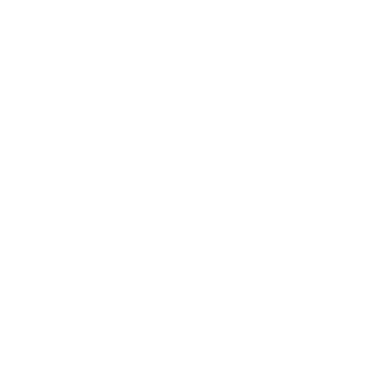

In [33]:
imgDensity = np.array(img)

# First generate stipple maps
stippleLevelMaps = []
for i in [10, 100, 1000, 5000, 7000, 8500, 15000, 20000, 25000]:
    stippleLevelMaps.append(generateStippleLevel(i+2, imgDensity.shape)[0].astype(int))

for i in range(len(stippleLevelMaps)):
    t = stippleLevelMaps[i]
    maxValue = t.max()
    newMap = np.zeros((maxValue, maxValue))
    for pixel in t:
        newMap[pixel[0]-1][pixel[1]-1] = 1
    stippleLevelMaps[i] = newMap
        
density = np.array(img)
zoom = (1000 * 500) / (density.shape[0]*density.shape[1])
zoom = int(round(np.sqrt(zoom)))
density = scipy.ndimage.zoom(density, zoom, order=0)

# Any intensity > threshold will be white
density = np.minimum(density, intensityThreshold) # Filters out pixels where intensity > threshold

density = 1.0 - ((density-density.min())/(density.max()-density.min()))
density = density[::-1, :]
newImgMap = np
points = []

xmin, xmax = 0, density.shape[1]
ymin, ymax = 0, density.shape[0]

fig = plt.figure(figsize=(5, 5),
                 facecolor="white")
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim([xmin, xmax])
ax.set_xticks([])
ax.set_ylim([ymin, ymax])
ax.set_yticks([])
points = np.array(points)
scatter = ax.scatter(points[:, 0], points[:, 1], s=1, 
                     facecolor="k", edgecolor="None")
Pi = points.astype(int)
X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
sizes = (1 +
         (300-300)*density[Y, X])
scatter.set_offsets(points)
scatter.set_sizes(sizes)

In [ ]:
# img2 = Image.open("boots_square_380.png").convert('L')
# density = np.array(img2)


zoom = (1000 * 500) / (density.shape[0]*density.shape[1])
zoom = int(round(np.sqrt(zoom)))
density = scipy.ndimage.zoom(density, zoom, order=0)

# Any intensity > threshold will be white
density = np.minimum(density, intensityThreshold) # Filters out pixels where intensity > threshold

density = 1.0 - ((density-density.min())/(density.max()-density.min()))
density = density[::-1, :]
newImgMap = np
points = []

xmin, xmax = 0, density.shape[1]
ymin, ymax = 0, density.shape[0]

for y in range(density.shape[0]-1):
    for x in range(density.shape[1]-1):
        if density[y][x] >= 0.0 and density[y][x] < 0.1:
            if stippleLevelMaps[0][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.1 and density[y][x] < 0.2:
            if stippleLevelMaps[1][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.2 and density[y][x] < 0.3:
            if stippleLevelMaps[2][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.3 and density[y][x] < 0.4:
            if stippleLevelMaps[3][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.4 and density[y][x] < 0.5:
            if stippleLevelMaps[4][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.5 and density[y][x] < 0.6:
            if stippleLevelMaps[5][y][x] == 1:
                points.append([x, y])        
        elif density[y][x] >= 0.6 and density[y][x] < 0.7:
            if stippleLevelMaps[6][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.7 and density[y][x] < 0.8:
            if stippleLevelMaps[7][y][x] == 1:
                points.append([x, y])
        elif density[y][x] >= 0.8 and density[y][x] < 0.9:
            if stippleLevelMaps[8][y][x] == 1:
                points.append([x, y])
fig = plt.figure(figsize=(5, 5),
                 facecolor="white")
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim([xmin, xmax])
ax.set_xticks([])
ax.set_ylim([ymin, ymax])
ax.set_yticks([])
points = np.array(points)
scatter = ax.scatter(points[:, 0], points[:, 1], s=1, 
                     facecolor="k", edgecolor="None")
Pi = points.astype(int)
X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
sizes = (5 +
         (300-300)*density[Y, X])
scatter.set_offsets(points)
scatter.set_sizes(sizes)